### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

### Загружаем данные

In [2]:
df = pd.read_csv('ebw_data.csv')
df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


величина сварочного тока - IW;
ток фокусировки электронного пучка - IF;
скорость сварки - VW;
расстояние от поверхности образцов до электронно-оптической системы - FP. 


In [3]:
df.isnull().sum() # проверяем данные на пропуски

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [4]:
df.duplicated().sum()  # и повторяющиеся значения

7

In [5]:
df = df.drop_duplicates() # удалим повторяющиеся значения

In [6]:
unique_vals = [df[col].unique() for col in df.columns.to_list()]    # посмотрим уникальные значения по столбцам
unique_vals

[array([47, 45, 46, 48, 49, 44, 43], dtype=int64),
 array([139, 140, 141, 134, 131, 132, 146, 150], dtype=int64),
 array([ 4.5,  8. , 10. , 12. ,  9. ]),
 array([ 80, 110, 125,  60,  50], dtype=int64),
 array([1.6 , 1.62, 1.68, 1.58, 1.76, 1.72, 1.64, 1.2 , 1.16, 0.98, 1.02,
        1.04, 1.  , 1.12, 1.08, 0.96, 0.92, 0.94, 1.36, 1.4 , 0.84, 0.86,
        0.88, 0.8 , 1.22, 1.18, 1.28, 1.24, 1.32]),
 array([2.54, 2.5 , 2.6 , 2.52, 2.48, 2.56, 2.  , 1.96, 1.84, 1.9 , 1.86,
        1.78, 1.8 , 1.71, 1.68, 1.72, 1.94, 2.16, 2.08, 2.04, 2.28, 2.24,
        1.76, 1.82, 1.88])]

In [7]:
df.describe()  # и распределение этих значений

,IW,IF,VW,FP,Depth,Width
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,45.769231,140.907692,8.669231,80.000000,1.192615,1.977077
std,1.674900,5.070512,2.097761,21.650635,0.234136,0.281945
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.040000,1.780000
50%,46.000000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.280000,2.080000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


### Визуализация данных для понимания основных зависимостей

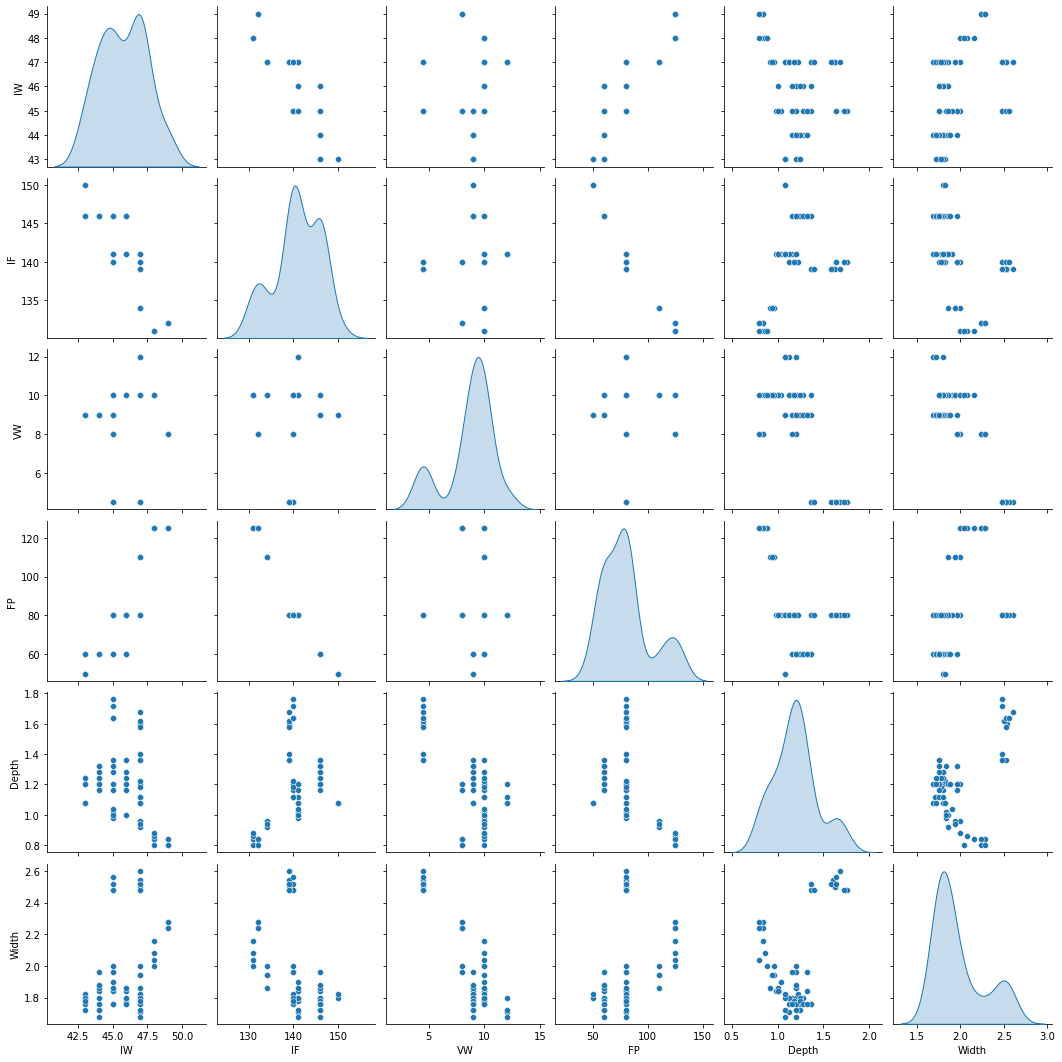

In [8]:
sns.pairplot(df, diag_kind='kde')

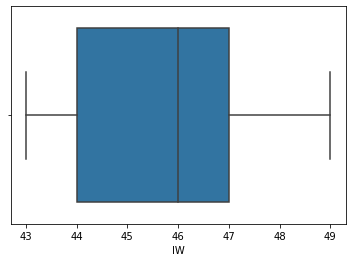

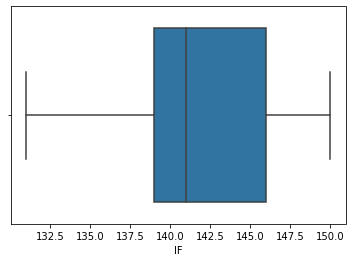

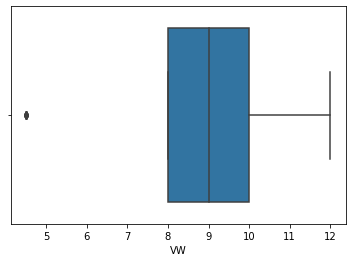

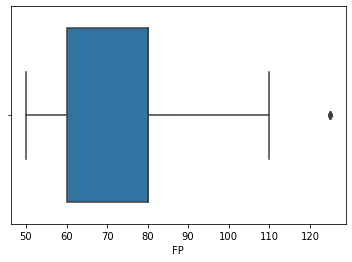

In [9]:
for col in df.columns.to_list()[:-2:]:
    sns.boxplot(x=df[col], )
    plt.show()

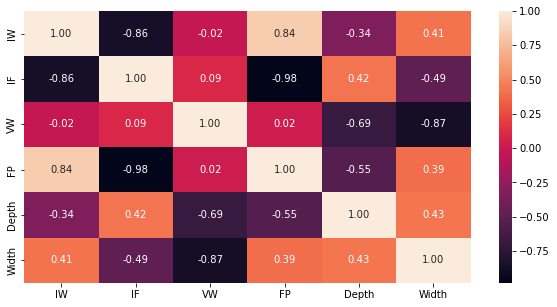

In [10]:
# построим матрицу корреляций
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

    Таким образом в исходнных данных:
    1. отсутствуют пропуски 
    2. величина и количество выбросов не значительны
    3. есть 7 дублирующихся записей
    4. отсутвуют категориальные признаки
    Это означает, что дополнительную обработку, кроме удаления дублирующихся значений можно не выполнять. Влияние наличия дубликатов на результаты моделей можно проверить отдельно.
    
    Кроме того целевые признаки достаточно сильно коррелируют с предикторами. С учетом малого размера набора данных и сильной корреляции не будем проводить понижение размерности.

### Выбор модели машинного обучения

In [11]:
from sklearn.multioutput import MultiOutputRegressor  # для предсказания двух параметров используем MultiOutputRegressor 

    Проведем оценку основных моделей для задачи регрессии из библиотеки sklearn. Поскольку датасет небольшой , проверку будем проводить десятикратной кросс-валидацией. В качестве оценки выберем  среднюю абсолютную ошибку из-за ее лучшей интерпретируемости

In [12]:
models = {"Linear":LinearRegression(), 
          "KNN":KNeighborsRegressor(),
          "SVR":SVR(),
          "DTR":DecisionTreeRegressor(random_state=42), 
          "RFR":RandomForestRegressor(random_state=42),
          "GBR":GradientBoostingRegressor(random_state=42), 
          "ABR":AdaBoostRegressor(random_state=42),
          "BR":BaggingRegressor(random_state=42),
         }

X = df.drop(['Depth', 'Width'], axis=1)
y = df[['Depth', 'Width']]

for model in models:
    score = -cross_val_score(MultiOutputRegressor(models[model]), X, y, cv=10, scoring='neg_mean_absolute_error').mean()
    print(f"{model}_MAE: {score.round(4)}")

Linear_MAE: 0.0859
KNN_MAE: 0.0844
SVR_MAE: 0.1499
DTR_MAE: 0.0858
RFR_MAE: 0.0767
GBR_MAE: 0.0716
ABR_MAE: 0.0866
BR_MAE: 0.086


    Для моделей чувствительных к нормированным данным проведем нормировку

In [13]:
mm_scaler = MinMaxScaler()
norm_df = mm_scaler.fit_transform(df)

X_norm = norm_df[:,:4] 
y_norm = norm_df[:,(4,5)] 

for model in models:
    score = -cross_val_score(MultiOutputRegressor(models[model]),X_norm, y_norm, cv=10, scoring='neg_mean_absolute_error').mean()
    print(f"{model}_MAE: {score.round(4)}")

Linear_MAE: 0.091
KNN_MAE: 0.0913
SVR_MAE: 0.0787
DTR_MAE: 0.0947
RFR_MAE: 0.0811
GBR_MAE: 0.0764
ABR_MAE: 0.0943
BR_MAE: 0.0876


нормализация данных повышеает качество на SVR-моедели, и не улучшает качество прогнозов на  остальныхмоделях

### Попробуем подстроить гиперпараметры и сравнить некоторые модели

#### GradientBoosting

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# параметры для подстройки
gb_params  = {
   'estimator__n_estimators':range(100,200,20),
    'estimator__min_samples_split':range(10,20,1)}

# модель для оптимизации
gm = MultiOutputRegressor(models["GBR"])
gb_model = GridSearchCV(gm, gb_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=10)
gb_model.fit(X_train, y_train)

# результаты лучшей модели
gb_predicts = gb_model.predict(X_test)
gb_r2 = r2_score(y_test,gb_predicts)
gb_mae = mean_absolute_error(y_test, gb_predicts)

print(f"Параметры модели: {gb_model.best_params_ } дают ошибку на кросс-валидации: {-gb_model.best_score_.round(4)}") 
print(f"На ТЕСТОВОЙ выборке R2= {gb_r2.round(4)}; МАЕ: {gb_mae.round(4)}")


Параметры модели: {'estimator__min_samples_split': 15, 'estimator__n_estimators': 100} дают ошибку на кросс-валидации: 0.0528
На ТЕСТОВОЙ выборке R2= 0.9493; МАЕ: 0.0432


6      4.5
69     9.0
4      4.5
51     9.0
38     8.0
20    12.0
61     9.0
64     9.0
62     9.0
53     9.0
33    10.0
47    10.0
68     9.0
16    10.0
28     4.5
27    10.0
25    10.0
50     9.0
12    10.0
34    10.0
65     9.0
49     9.0
39     8.0
30     4.5
45    10.0
52     9.0
1      4.5
22    12.0
2      4.5
57     9.0
41    10.0
37     8.0
24    10.0
60     9.0
10     8.0
23    12.0
19    10.0
63     9.0
40    10.0
21    12.0
7      4.5
44    10.0
15    10.0
29     4.5
56     9.0
Name: VW, dtype: float64

#### KNN_Regressor

In [17]:
knn_params ={
   'estimator__n_neighbors':[3, 5, 7, 9]
}

knn = MultiOutputRegressor(models["KNN"])
knn_model = GridSearchCV(knn, knn_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=10)
knn_model.fit(X_train, y_train)

knn_predicts = knn_model.predict(X_test)
knn_r2 = r2_score(y_test, knn_predicts)
knn_mae = mean_absolute_error(y_test, knn_predicts)

print(f"Параметры модели: {knn_model.best_params_ } дают ошибку на кросс-валидации: {-knn_model.best_score_.round(4)}") 
print(f"На ТЕСТОВОЙ выборке R2= {knn_r2.round(4)}; МАЕ: {knn_mae.round(4)}") 

Параметры модели: {'estimator__n_neighbors': 3} дают ошибку на кросс-валидации: 0.0703
На ТЕСТОВОЙ выборке R2= 0.9188; МАЕ: 0.0568


#### SVR

In [18]:
#разбиение нормированных данных
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)

svr_params = {
    'estimator__C':np.arange(1.0,5.5,0.5),
    'estimator__epsilon':np.arange(0.1,1.1,0.1)}

svr_mo = MultiOutputRegressor(models["SVR"])
svr_model = GridSearchCV(svr_mo, svr_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=10)
svr_model.fit(X_train_n,y_train_n)

predicts_svr = svr_model.predict(X_test_n)
svr_r2 = r2_score(y_test_n, predicts_svr)
svr_mae = mean_absolute_error(y_test_n, predicts_svr)

print(f"Параметры модели: {svr_model.best_params_ } дают ошибку на кросс-валидации: {-svr_model.best_score_.round(4)}") 
print(f"На ТЕСТОВОЙ выборке R2= {svr_r2.round(4)}; МАЕ: {svr_mae.round(4)}") 

Параметры модели: {'estimator__C': 2.0, 'estimator__epsilon': 0.1} дают ошибку на кросс-валидации: 0.0746
На ТЕСТОВОЙ выборке R2= 0.9175; МАЕ: 0.066


In [19]:
#cравним результаты с простой Линейной Регрессией
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)
lin_preds = lin_model.predict(X_test)
lr_r2 = r2_score(y_test, lin_preds)
lr_mae = mean_absolute_error(y_test, lin_preds)

print(f"На ТЕСТОВОЙ выборке R2= {lr_r2.round(4)}; МАЕ: {lr_mae.round(4)}") 

На ТЕСТОВОЙ выборке R2= 0.901; МАЕ: 0.0613


#### Таким образом, из выбранных моделей лучший результат дает метод Градиентого Бустинга

## Нейроcеть на KERAS

In [20]:
import tensorflow as tf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 731
Trainable params: 722
Non-trainable params: 9
__________________________________________________________

[0.007905141450464725, 0.07336685061454773]

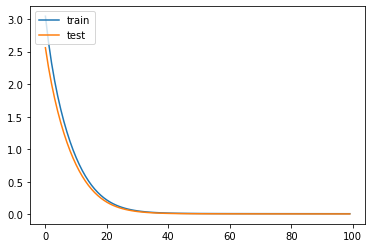

In [21]:
tf.random.set_seed(42)

normalizator = tf.keras.layers.Normalization(axis=1)
normalizator.adapt(X_train)
model = tf.keras.Sequential([
    normalizator,
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(2),
])
model.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.summary()

model.fit(X_train, y_train, epochs=100, validation_split=0.3, verbose=0)

fig = plt.plot(model.history.history['loss'])
fig = plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
model.evaluate(X_test, y_test)

#### Таким образом НС дала меньшую точность на тестовой выборке, чем GB и SVM.  Попробуем улучшить модель, обучив ее на искуственно синтезированных данных

In [22]:
# !pip install smogn

In [23]:
import smogn # библиотека позволяет применять SMOTE методы в задачах регрессии

In [24]:
# Cоздаем искусственный датасет
df = pd.read_csv('ebw_data.csv') # загружаем датасет заново, поскольку для синтеза данных лучше работает исходный датасет

smogn_df_depth = smogn.smoter(data=df, y='Depth', samp_method='extreme', 
                        rel_thres=1, rel_method='auto', rel_xtrm_type='both', rel_coef=2)
#smogn_df_width = smogn.smoter(data=df, y='Width', samp_method='extreme', 
#                        rel_thres=1, rel_method='auto', rel_xtrm_type='both', rel_coef=1.5)
new_df_depth = smogn_df_depth.reset_index(drop=True)
#new_df_width = smogn_df_width.reset_index(drop=True)
synth_df = pd.concat([df,new_df_depth]).reset_index(drop=True)

synth_df.shape

synth_matrix: 100%|#########################################################################################################################| 2/2 [00:00<00:00, 71.51it/s]


(212, 6)

(212, 7)

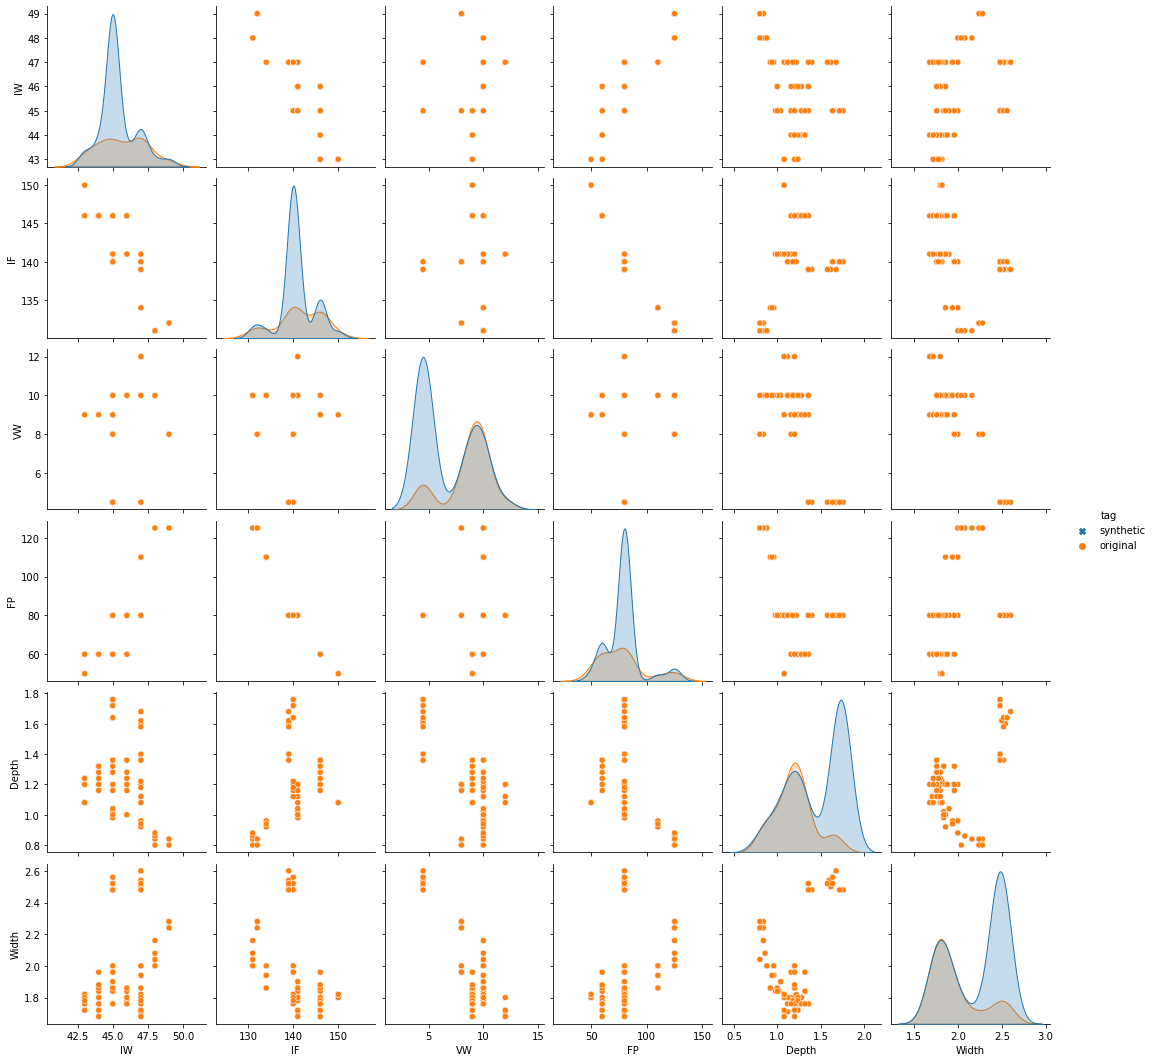

In [25]:
# Посмотрим как изменилось распределение для искуственных данных
new_df_depth['tag'] = 'synthetic'
df['tag'] = 'original'
combined_df = pd.concat([new_df_depth, df]).reset_index(drop=True)
sns.pairplot(combined_df, hue='tag', markers=["X", "o"])
combined_df.shape

In [26]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(synth_df[['IW','IF','VW','FP']], synth_df[['Depth','Width']], 
                                    test_size=0.3, random_state=42)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 731
Trainable params: 722
Non-trainable params: 9
__________________________________________________________

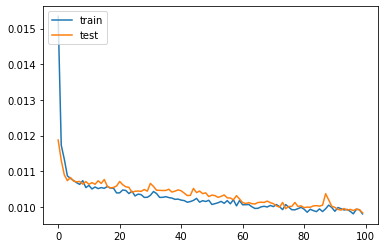

In [27]:
# Дообучим нейросеть на искуственных данных
model.summary()

model.fit(X_train_s, y_train_s, epochs=100, validation_split=0.3, verbose=0)

fig = plt.plot(model.history.history['loss'])
fig = plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

test_loss, nn_mae = model.evaluate(X_test_s, y_test_s)

    На искуственном увеличении датасета удалось немного улучшить точность предсказаний нейросети. Однако, результат все равно хуже чем у модели Градиентого Бустинга



#### Поскольку мы использовали модели предсказывающие сразу два параметра,  мы могли потерять в точности. Проверим будет ли выигрыш в точности, если предсказывать выходные параметры двумя моделями, настроенными отдельно на каждую целевую переменную

In [28]:
# заново подготовим данные
df = pd.read_csv('ebw_data.csv')
X = df.drop(['Depth', 'Width'], axis=1)
y_depth = df['Depth']
y_width = df['Width']

X_train_depth, X_test_depth, y_train_depth, y_test_depth = train_test_split(X, y_depth, test_size=0.3, random_state=42)
X_train_width, X_test_width, y_train_width, y_test_width = train_test_split(X, y_width, test_size=0.3, random_state=42)

In [29]:
# оптимизируем параметры для каждой модели
grid_search_params  = {
   'n_estimators':range(100,200,20),
    'min_samples_split':range(10,20,1)}

gs_depth_model = GridSearchCV(models['GBR'], grid_search_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=10)
gs_width_model = GridSearchCV(models['GBR'], grid_search_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=10)

gs_depth_model.fit(X_train_depth, y_train_depth)
gs_width_model.fit(X_train_width, y_train_width)

depth_results = gs_depth_model.best_params_ , -gs_depth_model.best_score_
width_results = gs_width_model.best_params_ , -gs_width_model.best_score_
results_mean = np.mean((depth_results[1], width_results[1])).round(4)

print(f"Параметры модели для глубины шва: {depth_results[0]}, МАЕ: {depth_results[1].round(4)}")
print(f"Параметры модели для ширины шва: {width_results[0]}, МАЕ: {width_results[1].round(4)}")
print(f"Средняя МАЕ по двум моделям: {results_mean}")
      

Параметры модели для глубины шва: {'min_samples_split': 17, 'n_estimators': 100}, МАЕ: 0.0501
Параметры модели для ширины шва: {'min_samples_split': 12, 'n_estimators': 100}, МАЕ: 0.0433
Средняя МАЕ по двум моделям: 0.0467


In [30]:
print(f"МАЕ модели с двумя выходами: {gb_mae.round(4)}, Средний MAE по двум моделям: {results_mean} ")

МАЕ модели с двумя выходами: 0.0432, Средний MAE по двум моделям: 0.0467 


Таким образом создание моделей с отдельными целевыми признаками не приводит к улучшению точности прогнозирования

In [31]:
maes = {"LinearRegression": lr_mae,
       "GradientBoosting":gb_mae,
       "KNN_Regressor":knn_mae,
       "SVR":svr_mae,
       "Neural_Network":nn_mae}
print("    Метод       : Метрика МАЕ")
for mae in maes:
    print(f"{(mae)}: {round(maes[mae],3)}")

    Метод       : Метрика МАЕ
LinearRegression: 0.061
GradientBoosting: 0.043
KNN_Regressor: 0.057
SVR: 0.066
Neural_Network: 0.068


### Победила модель - Gradient Boosting

## Сохраним лучшую модель

In [32]:
import pickle

In [33]:
with open('ebw_gb_model.pkl', 'wb') as f:
    pickle.dump(gb_model, f)